In [1]:
import os
import schnetpack as spk
from schnetpack.datasets import QM9
import schnetpack.transform as trn

import torch
import torchmetrics
import pytorch_lightning as pl

qm9tut = './qm9tut'
if not os.path.exists('qm9tut'):
    os.makedirs(qm9tut)


In [5]:
DB_PATH = "./qm9.db"
PROPERTIES = [QM9.homo, QM9.lumo]
PROPERTY = PROPERTIES #QM9.Cv
BATCH_SIZE = 16
NUM_TRAIN = 110000
NUM_VALIDATION = 10000
CUTOFF = 5.
N_ATOM_BASIS = 32
T = 3
EPOCHS = 3
LR = 1e-4
NUM_WORKERS = 1
PIN_MEMORY = True

In [6]:
qm9data = QM9(
    DB_PATH,
    batch_size=BATCH_SIZE,
    num_train=NUM_TRAIN,
    num_val=NUM_VALIDATION,
    transforms=[
        trn.ASENeighborList(cutoff=float(CUTOFF)),
        #trn.RemoveOffsets(PROPERTY, remove_mean=True, remove_atomrefs=True),
        trn.CastTo32()
    ],
    num_workers=NUM_WORKERS,
    split_file=os.path.join(qm9tut, "split.npz"),
    pin_memory=PIN_MEMORY, # set to false, when not using a GPU
    load_properties=PROPERTY, #only load U0 property
)
qm9data.prepare_data()
qm9data.setup()

INFO:root:Downloading GDB-9 atom references...
INFO:root:Done.
INFO:root:Downloading GDB-9 data...
INFO:root:Done.
INFO:root:Extracting files...
INFO:root:Done.
INFO:root:Parse xyz files...
100%|██████████| 133885/133885 [01:04<00:00, 2085.35it/s]
INFO:root:Write atoms to db...
INFO:root:Done.


In [35]:
import torch

model_path_homo = 'weights/best_homo_e50.pt'
model_path_lumo = 'weights/best_lumo_e50.pt'
model_path_homo_lumo = 'weights/best_homo_lumo_e50.pt'

trained_model_homo = torch.load(os.path.join(qm9tut, model_path_homo), map_location=torch.device('cpu'))
trained_model_lumo = torch.load(os.path.join(qm9tut, model_path_lumo), map_location=torch.device('cpu'))
trained_model_homo_lumo = torch.load(os.path.join(qm9tut, model_path_homo_lumo), map_location=torch.device('cpu'))

""" for name, param in trained_model_homo.state_dict().items():
    print(name, param.shape) """

' for name, param in trained_model_homo.state_dict().items():\n    print(name, param.shape) '

In [56]:
# Molecule:
import numpy as np
from ase import Atoms

converter = spk.interfaces.AtomsConverter(neighbor_list=trn.ASENeighborList(cutoff=float(CUTOFF)), 
                                          dtype=torch.float32) #,
                                          #device='cuda')
numbers = np.array([6, 1, 1, 1, 1])
positions = np.array([[-0.0126981359, 1.0858041578, 0.0080009958],
                      [0.002150416, -0.0060313176, 0.0019761204],
                      [1.0117308433, 1.4637511618, 0.0002765748],
                      [-0.540815069, 1.4475266138, -0.8766437152],
                      [-0.5238136345, 1.4379326443, 0.9063972942]])
atoms = Atoms(numbers=numbers, positions=positions)

In [57]:
# https://compass.blogs.bristol.ac.uk/2023/02/17/student-perspectives-an-introduction-to-graph-neural-networks-gnns/
# Oda og jeg kan godt lide link. it helps. with life.

def get_digest_inf_input(trained_model, inputs):
    digest_inf_input = []

    def forward_hook_in_callback(module, input, output):
        digest_inf_input.append(input)

    model_layer_inf_input = trained_model.output_modules[0].outnet[0]
    hook_handle_inf_input = model_layer_inf_input.register_forward_hook(forward_hook_in_callback)

    trained_model.eval()
    pred = trained_model(inputs)

    """ print(f"Number of digests captured by forward pass hook input: {len(digest_inf_input)}")

    for d in digest_inf_input:
        print(d[0])
        print(d[0].shape) """

    hook_handle_inf_input.remove()
    return pred, digest_inf_input

In [150]:
# Extracting the digests and the model predictions
inputs_homo = converter(atoms)
inputs_lumo = inputs_homo.copy()
inputs_homo_lumo = inputs_homo.copy()

pred_h, digest_h = get_digest_inf_input(trained_model_homo, inputs_homo)
pred_l, digest_l = get_digest_inf_input(trained_model_lumo, inputs_lumo)
pred_hl, digest_hl = get_digest_inf_input(trained_model_homo_lumo, inputs_homo_lumo)

#digest_hl

In [ ]:
# Converting digests to numpy arrays

with torch.no_grad():
    digest_l_numpy = digest_l[0][0].numpy()
    digest_h_numpy = digest_h[0][0].numpy()
    digest_hl_numpy = digest_hl[0][0].numpy()

In [173]:
# Eucledian distance between digests

dist = np.array([])
for num_atoms in range(numbers.size):
    dist = np.append(dist, np.linalg.norm(digest_h_numpy[num_atoms] - digest_l_numpy[num_atoms]))
print(dist)

dist2 = np.array([])
for num_atoms in range(numbers.size):
    dist2 = np.append(dist2, np.linalg.norm(digest_hl_numpy[num_atoms] - digest_l_numpy[num_atoms]))
print(dist2)

dist3 = np.array([])
for num_atoms in range(numbers.size):
    dist3 = np.append(dist3, np.linalg.norm(digest_hl_numpy[num_atoms] - digest_h_numpy[num_atoms]))
print(dist3)


[6.12124395 4.61033344 4.61033344 4.61033678 4.6103363 ]
[6.93604565 4.38540697 4.38540792 4.38541031 4.38540936]
[5.24911928 4.12730074 4.12730122 4.12730408 4.1273036 ]


In [174]:
# Model predictions

print('Prediction:', pred_h[QM9.homo].item())
print('Prediction:', pred_hl[QM9.homo].item())
# single homo model: -0.1053
# combined model: -0.0661
# dif: 0.0392
print('Prediction:', pred_l[QM9.lumo].item())
print('Prediction:', pred_hl[QM9.lumo].item())
# single lumo model: 0.0247
# combined model: 0.0274
# dif: 0.0027

Prediction: -0.10534591972827911
Prediction: -0.0660596489906311
Prediction: 0.024705849587917328
Prediction: 0.02740728110074997


### Plotting representation

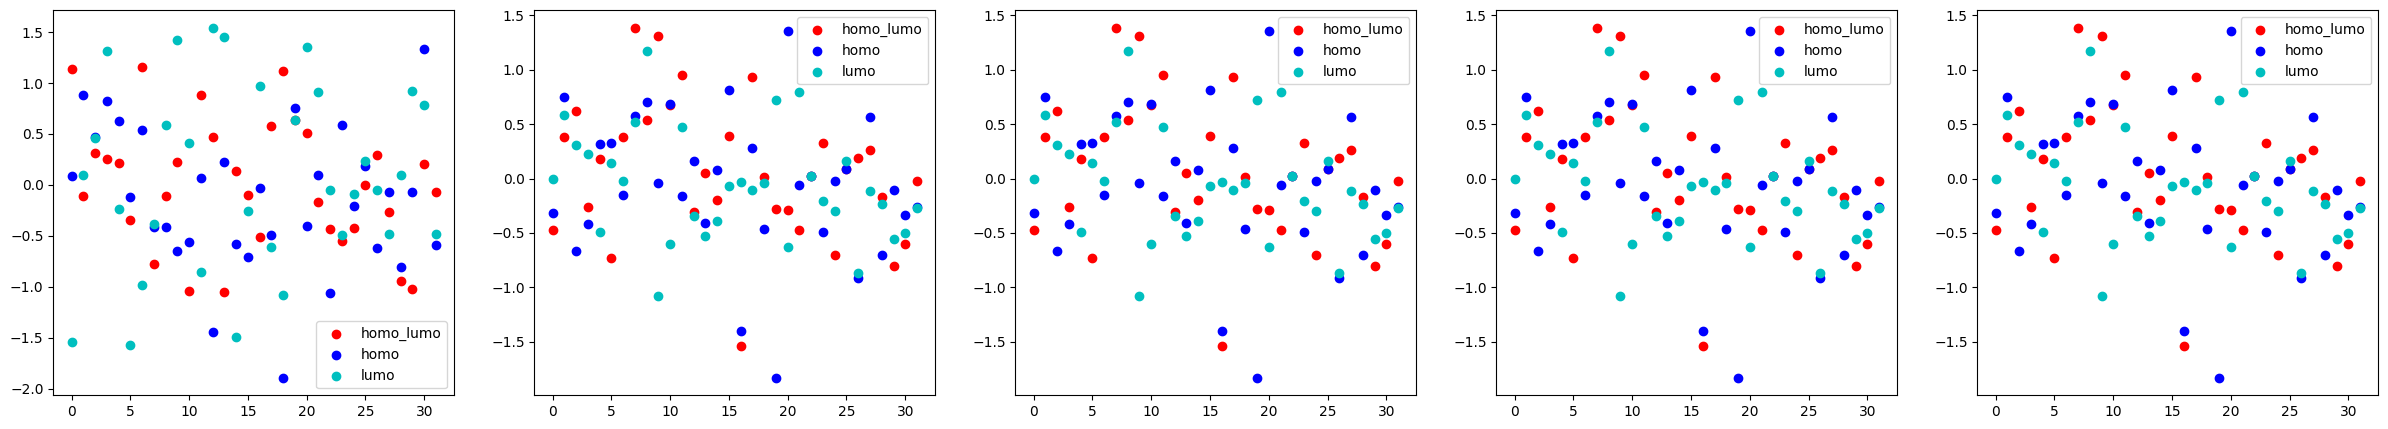

In [148]:
import matplotlib.pyplot as plt

x = np.linspace(0,31,32)

fig, ax = plt.subplots(1,numbers.size, sharex=True, figsize=(30,5))

for num_atoms in range(numbers.size):
    ax[num_atoms].scatter(x, digest_hl_numpy[num_atoms], c = 'r', label = 'homo_lumo')
    ax[num_atoms].scatter(x,digest_h_numpy[num_atoms], c = 'b', label = 'homo')
    ax[num_atoms].scatter(x,digest_l_numpy[num_atoms], c = 'c', label = 'lumo')
    ax[num_atoms].legend()
plt.show()


### Cosine Similarity

In [172]:
#digest_l[0][0][0]

In [171]:
# Cosine similarity with function

from torch import tensor
from torchmetrics.regression import CosineSimilarity
cosine_similarity = CosineSimilarity(reduction='mean')
test = cosine_similarity(digest_h[0][0][0], digest_l[0][0][0])
print(test)

test2 = cosine_similarity(digest_h[0][0][0], digest_hl[0][0][0])
print(test2)

test3 = cosine_similarity(digest_l[0][0][0], digest_hl[0][0][0])
print(test3)


tensor(0.1006, grad_fn=<SqueezeBackward0>)
tensor(0.0138, grad_fn=<SqueezeBackward0>)
tensor(-0.2846, grad_fn=<SqueezeBackward0>)


In [168]:
# Cosine similarity manual

from numpy.linalg import norm

cos_sim_h_l = np.array([])
cos_sim_h_hl = np.array([])
cos_sim_l_hl = np.array([])


for num_atoms in range(numbers.size):
    # cos_sim_h_l
    cos_sim_h_l = np.append(cos_sim_h_l, np.dot(digest_h_numpy[num_atoms], digest_l_numpy[num_atoms]) / (norm(digest_h_numpy[num_atoms])*norm(digest_l_numpy[num_atoms])))
    # cos_sim_h_hl
    cos_sim_h_hl = np.append(cos_sim_h_hl, np.dot(digest_h_numpy[num_atoms], digest_hl_numpy[num_atoms]) / (norm(digest_h_numpy[num_atoms])*norm(digest_hl_numpy[num_atoms])))
    # cos_sim_l_hl
    cos_sim_l_hl = np.append(cos_sim_l_hl, np.dot(digest_l_numpy[num_atoms], digest_hl_numpy[num_atoms]) / (norm(digest_l_numpy[num_atoms])*norm(digest_hl_numpy[num_atoms])))

print(cos_sim_h_l)
print(cos_sim_h_hl)
print(cos_sim_l_hl)


[ 0.10064439 -0.00697791 -0.00697813 -0.00697913 -0.00697889]
[0.01379816 0.33915433 0.33915427 0.33915415 0.33915421]
[-0.28459254  0.05687658  0.05687642  0.05687691  0.05687714]


### Confusion Matrix

In [178]:
import seaborn as sns

In [210]:
# plot confusion matrix
def plot_confusion_matrix(data, labels, title):
    """Plot confusion matrix using heatmap.
 
    Args:
        data (list of list): List of lists with confusion matrix data.
        labels (list): Labels which will be plotted across x and y axis.
        output_filename (str): Path to output file.
 
    """
    sns.set(color_codes=True)
    plt.figure(1, figsize=(4,3))
    plt.title(title)
 
    sns.set(font_scale=1.4)
    ax = sns.heatmap(data, annot=True, cbar_kws={'label': 'Scale'}, vmin = -1, vmax = 1)
    # cmap="PiYG", el. center=0

    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set(ylabel="Model", xlabel="Model")
 
    plt.show()

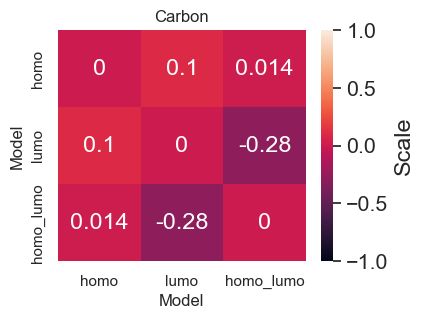

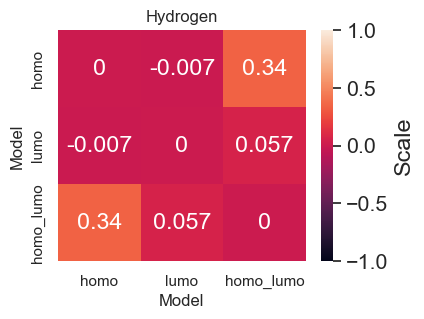

In [211]:
# Confussion matrix of Carbon methane
labels = ["homo", "lumo", "homo_lumo"]
data = [[ 0, cos_sim_h_l[0], cos_sim_h_hl[0]],
        [cos_sim_h_l[0], 0, cos_sim_l_hl[0]], 
        [cos_sim_h_hl[0], cos_sim_l_hl[0],0 ]]
plot_confusion_matrix(data, labels, "Carbon")


# Confussion matrix of Hydrogen in methane
labels = ["homo", "lumo", "homo_lumo"]
data = [[ 0, cos_sim_h_l[1], cos_sim_h_hl[1]],
        [cos_sim_h_l[1], 0, cos_sim_l_hl[1]], 
        [cos_sim_h_hl[1], cos_sim_l_hl[1],0 ]]
plot_confusion_matrix(data, labels, "Hydrogen")                
